## Pairs Trading Strategy

Pairs trading is a market-neutral trading strategy that involves the simultaneous buying and selling of two highly correlated financial instruments, such as two stocks, to profit from the relative price movements between them.

1. Use cointegration test to find two stocks that are cointegrated. Cointegration is a statistical concept that decribes a long-term relationship between 2 or more non-stationary time series variables.

2. Obtain a normal range of historical spread for the pair of cointegrated assets.

3. Compare current spread with historical spreads to assess if the former exceeds a normal range.

4. If short-term fluctuations occurs due to market fluctuations, buy the underperforming asset while short-selling the overperforming asset.

5. When the current spread reverts back to the normal range, exit the positions and lock in a profit.

In [53]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import coint
%matplotlib inline

SEED = 8
random.seed(SEED)
np.random.seed(SEED)

# Implement pairs trading

In [86]:
# download data from yfinance
forex = ['EURUSD=X','USDJPY=X','GBPUSD=X','USDCHF=X','AUDUSD=X','USDCAD=X','NZDUSD=X']
start_date = '2022-11-01'
end_date = '2023-11-01'
df = yf.download(forex, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%%**********************]  7 of 7 completed


,AUDUSD=X,EURUSD=X,GBPUSD=X,NZDUSD=X,USDCAD=X,USDCHF=X,USDJPY=X
Date,,,,,,,
2022-11-01,0.640990,0.988631,1.146815,0.582520,1.36107,1.00141,148.737000
2022-11-02,0.639670,0.987791,1.148950,0.584789,1.36180,0.99970,147.914993
2022-11-03,0.633850,0.981441,1.138433,0.581341,1.37152,1.00328,147.891998
2022-11-04,0.628852,0.974963,1.117119,0.576921,1.37424,1.01342,148.393005
2022-11-07,0.643932,0.992881,1.133157,0.589421,1.35125,0.99674,146.841003


## Perform cointegration test

In [87]:
from itertools import combinations

# get all pairs of stocks
forex_pairs = list(combinations(df.columns, 2))
forex_pairs

[('AUDUSD=X', 'EURUSD=X'),
 ('AUDUSD=X', 'GBPUSD=X'),
 ('AUDUSD=X', 'NZDUSD=X'),
 ('AUDUSD=X', 'USDCAD=X'),
 ('AUDUSD=X', 'USDCHF=X'),
 ('AUDUSD=X', 'USDJPY=X'),
 ('EURUSD=X', 'GBPUSD=X'),
 ('EURUSD=X', 'NZDUSD=X'),
 ('EURUSD=X', 'USDCAD=X'),
 ('EURUSD=X', 'USDCHF=X'),
 ('EURUSD=X', 'USDJPY=X'),
 ('GBPUSD=X', 'NZDUSD=X'),
 ('GBPUSD=X', 'USDCAD=X'),
 ('GBPUSD=X', 'USDCHF=X'),
 ('GBPUSD=X', 'USDJPY=X'),
 ('NZDUSD=X', 'USDCAD=X'),
 ('NZDUSD=X', 'USDCHF=X'),
 ('NZDUSD=X', 'USDJPY=X'),
 ('USDCAD=X', 'USDCHF=X'),
 ('USDCAD=X', 'USDJPY=X'),
 ('USDCHF=X', 'USDJPY=X')]

In [88]:
threshold = 0.1
# run Engle-Granger test for cointegration on each pair of stocks
for pair in forex_pairs:
    # subset df based on current pair of stocks
    df2 = df[list(pair)]
    # perform test for the current pair of stocks
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
    # check if the current pair of stocks is cointegrated
    if pvalue < threshold:
        print(pair, 'are cointegrated')
    else:
        print(pair, 'are not cointegrated')

('AUDUSD=X', 'EURUSD=X') are not cointegrated
('AUDUSD=X', 'GBPUSD=X') are not cointegrated
('AUDUSD=X', 'NZDUSD=X') are cointegrated
('AUDUSD=X', 'USDCAD=X') are not cointegrated
('AUDUSD=X', 'USDCHF=X') are not cointegrated
('AUDUSD=X', 'USDJPY=X') are cointegrated
('EURUSD=X', 'GBPUSD=X') are not cointegrated
('EURUSD=X', 'NZDUSD=X') are cointegrated
('EURUSD=X', 'USDCAD=X') are cointegrated
('EURUSD=X', 'USDCHF=X') are not cointegrated
('EURUSD=X', 'USDJPY=X') are cointegrated
('GBPUSD=X', 'NZDUSD=X') are not cointegrated
('GBPUSD=X', 'USDCAD=X') are not cointegrated
('GBPUSD=X', 'USDCHF=X') are not cointegrated
('GBPUSD=X', 'USDJPY=X') are not cointegrated
('NZDUSD=X', 'USDCAD=X') are not cointegrated
('NZDUSD=X', 'USDCHF=X') are not cointegrated
('NZDUSD=X', 'USDJPY=X') are cointegrated
('USDCAD=X', 'USDCHF=X') are not cointegrated
('USDCAD=X', 'USDJPY=X') are not cointegrated
('USDCHF=X', 'USDJPY=X') are not cointegrated


## Obtain spread series

<Axes: xlabel='Date'>

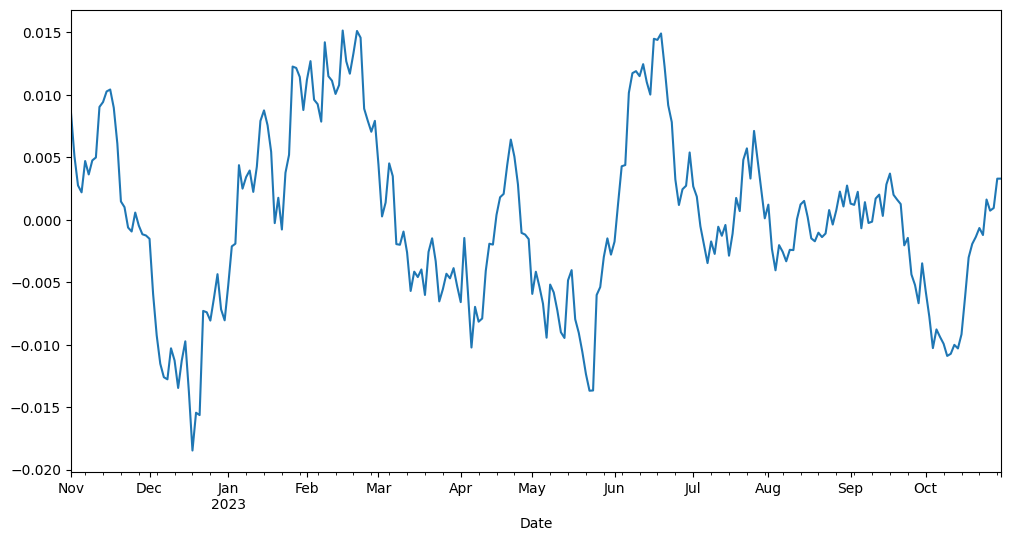

In [89]:
# calculate the spread for GOOG and MSFT
Y = df["AUDUSD=X"]
X = df["NZDUSD=X"]
# estimate linear regression coefficients
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
# obtain the spread as the residuals
spread = Y - model.predict()
spread.plot(figsize=(12,6))

## Converting to z-scores

<Axes: xlabel='Date'>

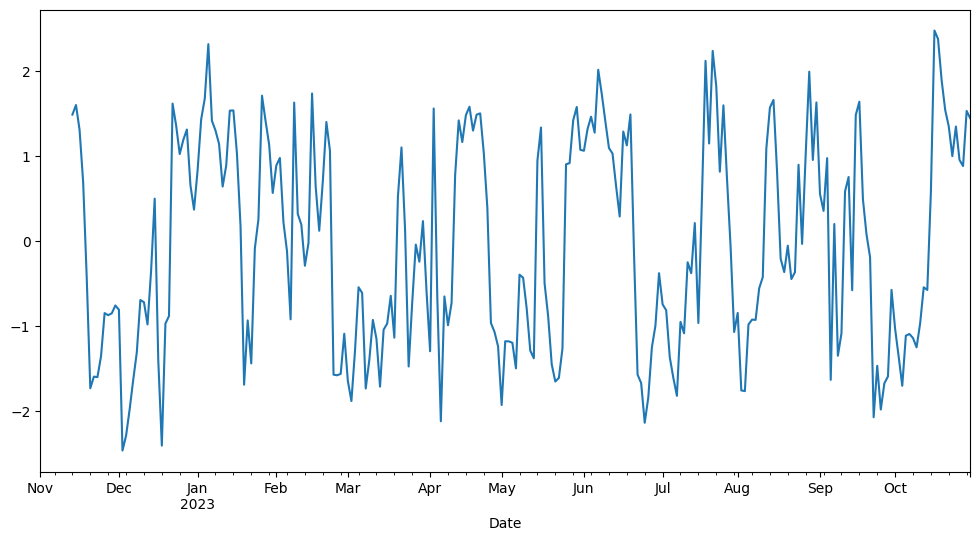

In [90]:
# convert to z score
# z-score is a measure of how many standard deviations the spread is from its mean
# derive mean and sd using a moving window
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = (spread - spread_mean) / spread_std
zscore.plot(figsize=(12,6))

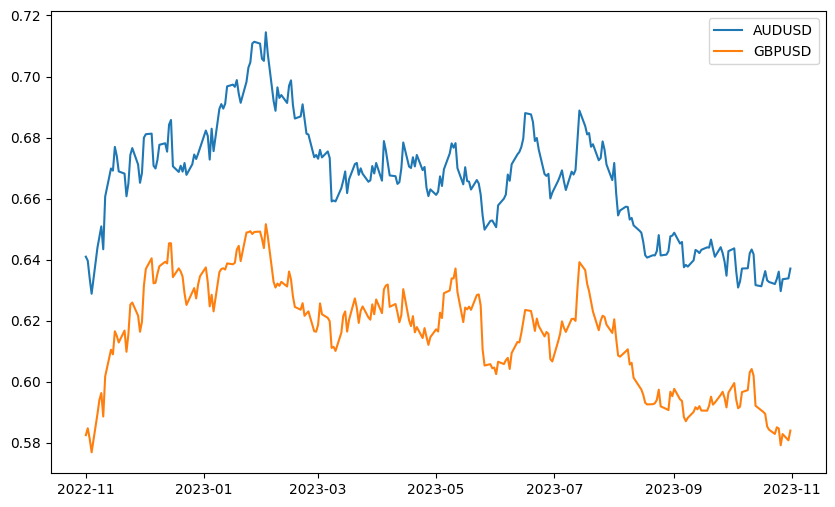

In [91]:
plt.figure(figsize=(10,6))
plt.plot(df['AUDUSD=X'], label = 'AUDUSD')
plt.plot(df['NZDUSD=X'], label = 'GBPUSD')
plt.legend()

<Axes: xlabel='Date'>

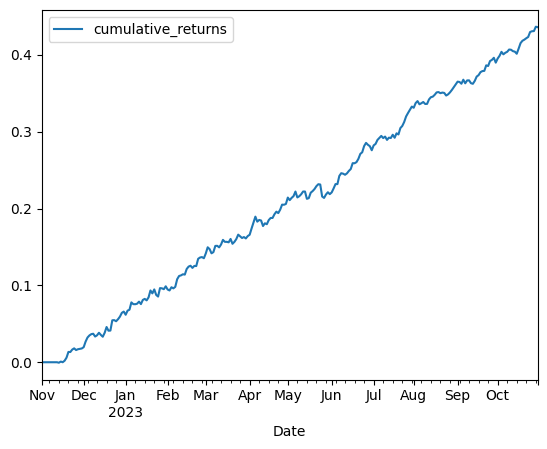

In [95]:
# Set zscore threshold
zscore_threshold = 1.0

# Calculate the percentage change for each forex pair
df["AUDUSD_returns"] = df['AUDUSD=X'].pct_change()
df["NZDUSD_returns"] = df['NZDUSD=X'].pct_change()

# Create Signals
df["Signal_AUDUSD"] = np.where(zscore > zscore_threshold, 1, 0)
df["Signal_AUDUSD"] = np.where(zscore < zscore_threshold, -1, df['Signal_AUDUSD'])
df["Signal_NZDUSD"] = np.where(zscore > zscore_threshold, -1, 0)
df["Signal_NZDUSD"] = np.where(zscore < zscore_threshold, 1, df['Signal_NZDUSD'])

# Calculate returns for the two pairs
df["pts1_returns"] = df["Signal_AUDUSD"] * df["AUDUSD_returns"]
df["pts2_returns"] = df["Signal_NZDUSD"] * df["NZDUSD_returns"]

# Add the two returns
df["pt_returns"] = df["pts1_returns"] + df["pts2_returns"]

# Calculate cumulative returns
df['cumulative_returns'] = (df["pt_returns"]+1).cumprod()-1
df[["cumulative_returns"]].plot()

In [100]:
terminal_return = round(df['cumulative_returns'][-1],4) * 100
print(f"The total cumulative returns for Pairs Trading strategy is {terminal_return}%")

The total cumulative returns for Pairs Trading strategy is 43.61%
